In [1]:
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.utils import plot_model

import keras
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import json

Using TensorFlow backend.


In [2]:
f = open('data.json', encoding="utf8")
data = json.load(f)
len(data)

3737

In [3]:
for d in data:
    d['text'] = d['title'] + d['text']

In [4]:
df = pd.DataFrame(data)
del df['website']
del df['title']
df.head()

,labels,text
0,[Coronavirus],Coronavirus: Royal Mail's Derry staff in stand...
1,"[US election 2020, Donald Trump]",US election 2020 polls: Who is ahead - Trump o...
2,"[Personal finance, Companies, Retailing, Coron...",Visa and Mastercard accused of charging 'exces...
3,[United States],Jeff Bridges: Oscar-winning US actor reveals h...
4,"[Boris Johnson, Brexit]",Brexit: Have EU-UK trade talks reached a dead ...


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['labels'])
number_of_classes = y.shape[1]
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [6]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [7]:
X = []
sentences = list(df["text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [8]:
print("Before:\n" + df["text"][0])
print()
print("After:\n" + X[0])

Before:
Coronavirus: Royal Mail's Derry staff in standoff over deep cleanRoyal Mail staff in Londonderry have refused to enter the city's sorting office until a deep clean of the premises is carried out. More than 40 staff - a third of its 120-strong workforce - are off work because of Covid-19, the Communication Workers' Union (CWU) said. The union said 17 staff at the office have tested positive, with 13 of those having been diagnosed since Friday. A further 25 members of staff are self-isolating, it added. The CWU's Charlie Kelly said it is a "scary time for staff". He said it is "highly unlikely" there will be a postal service in the city on Tuesday. "Staff want a commitment as to when it (the deep clean) is going to get done," he said.  "Until we get that commitment they say they are not going back into the building because they feel their health and safety is under threat." Staff and management are due to hold talks later on Tuesday morning. There have been 4,292 confirmed cases 

In [9]:
tags = {}
for t in mlb.classes_:
    tags[t] = 0
for l in df['labels']:
    for t in l:
        tags[t] += 1

for t in tags:
    tags[t] = (int)(tags[t]*0.2)

# val_tags = {}
# for t in tags:
#     val_tags[t] = (int)(tags[t])

val_tags = tags.copy()

In [10]:
X_train = []
X_test = []
X_val = []

y_train = np.empty(shape=(0,len(mlb.classes_)),dtype=int)
y_test = np.empty(shape=(0,len(mlb.classes_)),dtype=int)
y_val = np.empty(shape=(0,len(mlb.classes_)),dtype=int)

for x in range(len(X)):
    flag = 0
    for t in df.iloc[x]['labels']:
        if(tags[t] > 0):
            flag = 1
            break;
        elif(val_tags[t] > 0):
            flag = 2
            break;
        
    if flag == 1:
        for t in df.iloc[x]['labels']:
            tags[t] -= 1
        X_test.append(df.iloc[x]['text'])
        y_test = np.vstack([y_test, y[x]])
    elif flag == 2:
        for t in df.iloc[x]['labels']:
            val_tags[t] -= 1
        X_val.append(df.iloc[x]['text'])
        y_val = np.vstack([y_val, y[x]])
    else:
        X_train.append(df.iloc[x]['text'])
        y_train = np.vstack([y_train, y[x]])

In [11]:
print(f"Splitted to train {len(X_train)}, validation {len(X_val)} and test {len(X_test)} ")

Splitted to train 2228, validation 780 and test 729 


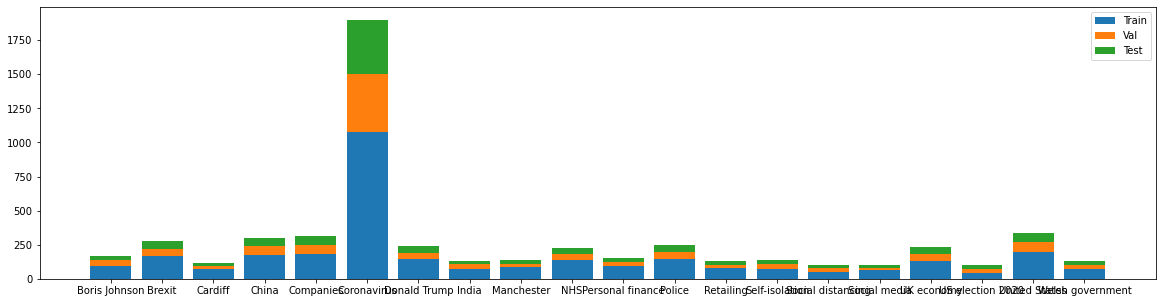

In [12]:
sum_y = y.sum(axis = 0)
sum_y_train = y_train.sum(axis = 0)
sum_y_test = y_test.sum(axis = 0)
sum_y_val = y_val.sum(axis = 0)

xloc = np.arange(y.shape[1])
barWidth = 0.8

#display stacked bar chart
plt.figure(figsize=(20,5))
p1 = plt.bar(xloc, sum_y_train, width=barWidth)
p2 = plt.bar(xloc, sum_y_val, bottom=sum_y_train, width=barWidth)
p3 = plt.bar(xloc, sum_y_test, bottom=sum_y_train+sum_y_val, width=barWidth)
plt.xticks(xloc, mlb.classes_)
plt.legend((p1[0], p2[0], p3[0]), ('Train', 'Val', 'Test'))
# plt.savefig("train_test_split_ratio.png")
plt.show()

In [13]:
# We have imbalanced data, so we will use class_weight
class_weight = {}
for x in range(number_of_classes):
    class_weight[x] = (1 / sum_y[x])*(len(data))/number_of_classes
class_weight

{0: 1.0991176470588235,
 1: 0.6745487364620939,
 2: 1.597008547008547,
 3: 0.63125,
 4: 0.5969648562300319,
 5: 0.09844573234984193,
 6: 0.7689300411522634,
 7: 1.415530303030303,
 8: 1.3442446043165468,
 9: 0.8195175438596491,
 10: 1.2212418300653596,
 11: 0.7564777327935223,
 12: 1.4484496124031008,
 13: 1.3346428571428572,
 14: 1.831862745098039,
 15: 1.831862745098039,
 16: 0.801931330472103,
 17: 1.8684999999999998,
 18: 0.5611111111111111,
 19: 1.4373076923076924}

In [14]:
for x in range(len(sum_y_train)):
    print(f" \t{sum_y_train[x]}\t{sum_y_test[x]}, {sum_y_test[x]/sum_y[x]*100:0.2f}%\t{sum_y_val[x]}, {sum_y_val[x]/sum_y[x]*100:0.2f}%")

 	97	35, 20.59%	38, 22.35%
 	166	56, 20.22%	55, 19.86%
 	70	23, 19.66%	24, 20.51%
 	177	59, 19.93%	60, 20.27%
 	185	64, 20.45%	64, 20.45%
 	1078	399, 21.02%	421, 22.18%
 	142	52, 21.40%	49, 20.16%
 	73	26, 19.70%	33, 25.00%
 	83	27, 19.42%	29, 20.86%
 	138	45, 19.74%	45, 19.74%
 	93	30, 19.61%	30, 19.61%
 	146	50, 20.24%	51, 20.65%
 	79	25, 19.38%	25, 19.38%
 	75	30, 21.43%	35, 25.00%
 	51	21, 20.59%	30, 29.41%
 	61	20, 19.61%	21, 20.59%
 	133	49, 21.03%	51, 21.89%
 	41	25, 25.00%	34, 34.00%
 	197	66, 19.82%	70, 21.02%
 	70	26, 20.00%	34, 26.15%


In [15]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val = pad_sequences(X_val, padding='post', maxlen=maxlen)

In [16]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [17]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen, weights=[embedding_matrix], trainable=False))
# model.add(LSTM(128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(number_of_classes, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          3966800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                5140      
Total params: 4,206,436
Trainable params: 239,636
Non-trainable params: 3,966,800
_________________________________________________________________


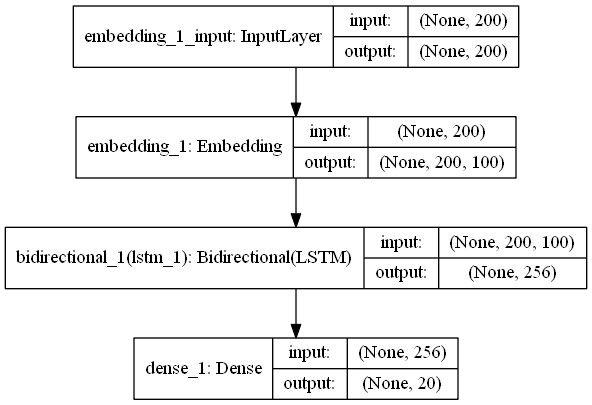

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
epoch_num = 20
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=epoch_num,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    class_weight=class_weight)

Train on 2228 samples, validate on 780 samples
Epoch 1/20
2228/2228 [==============================] - 19s 9ms/step - loss: 0.2175 - acc: 0.8756 - val_loss: 0.2568 - val_acc: 0.9231
Epoch 2/20
2228/2228 [==============================] - 20s 9ms/step - loss: 0.1426 - acc: 0.9292 - val_loss: 0.2552 - val_acc: 0.9231
Epoch 3/20
2228/2228 [==============================] - 22s 10ms/step - loss: 0.1395 - acc: 0.9292 - val_loss: 0.2454 - val_acc: 0.9231
Epoch 4/20
2228/2228 [==============================] - 23s 10ms/step - loss: 0.1379 - acc: 0.9292 - val_loss: 0.2482 - val_acc: 0.9231
Epoch 5/20
2228/2228 [==============================] - 24s 11ms/step - loss: 0.1353 - acc: 0.9292 - val_loss: 0.2446 - val_acc: 0.9231
Epoch 6/20
2228/2228 [==============================] - 25s 11ms/step - loss: 0.1329 - acc: 0.9292 - val_loss: 0.2392 - val_acc: 0.9231
Epoch 7/20
2228/2228 [==============================] - 26s 12ms/step - loss: 0.1283 - acc: 0.9292 - val_loss: 0.2318 - val_acc: 0.9231
Epo

In [20]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

729/729 [==============================] - 2s 3ms/step
Test Score: 0.1836823401218906
Test Accuracy: 0.9318243861198425


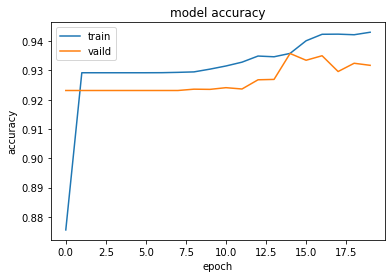

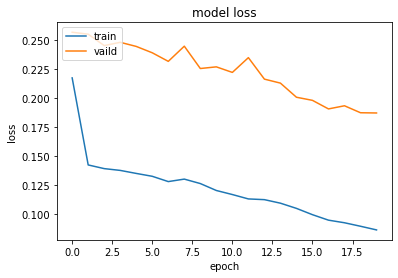

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.savefig("glove_acc.png")
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','vaild'], loc='upper left')
plt.savefig("glove_loss.png")
plt.show()